<a href="https://colab.research.google.com/github/SebasArceCR/Prueba/blob/main/Proyecto-Investigacion/Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificacion de sonidos estridentes con espectrogramas

**Integrantes:**
- Christopher Víquez Aguilar - christopherviquezaguilar@gmail.com
- Sebastian Arce Flores - sebasarc0224@hotmail.com

# Librerias y dependencias

In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAvgPool2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import matplotlib.pyplot as plt
import random
import os
import glob
import requests
from collections import defaultdict

# Datos

## Descarga de datos

In [ ]:
def download_github_folder_recursive(owner, repo, folder_path, local_base_path, branch='main'):
    """
    Descarga recursivamente una carpeta completa de GitHub manteniendo la estructura
    """
    api_url = f"https://api.github.com/repos/{owner}/{repo}/contents/{folder_path}"

    try:
        response = requests.get(api_url)
        if response.status_code != 200:
            print(f"Error accessing {folder_path}: {response.status_code}")
            return

        items = response.json()

        # Crear directorio local si no existe
        local_folder_path = os.path.join(local_base_path, folder_path)
        os.makedirs(local_folder_path, exist_ok=True)

        for item in items:
            if item['type'] == 'file':
                # Descargar archivo
                file_url = f"https://raw.githubusercontent.com/{owner}/{repo}/{branch}/{folder_path}/{item['name']}"
                file_response = requests.get(file_url)

                if file_response.status_code == 200:
                    file_path = os.path.join(local_folder_path, item['name'])
                    with open(file_path, 'wb') as f:
                        f.write(file_response.content)
                    print(f"✓ Descargado: {folder_path}/{item['name']}")
                else:
                    print(f"✗ Error descargando: {folder_path}/{item['name']}")

            elif item['type'] == 'dir':
                # Llamada recursiva para subdirectorios
                subfolder_path = f"{folder_path}/{item['name']}" if folder_path else item['name']
                download_github_folder_recursive(owner, repo, subfolder_path, local_base_path, branch)

    except Exception as e:
        print(f"Error procesando {folder_path}: {str(e)}")

def download_sound_dataset_from_github(owner, repo, dataset_folder="Sounds-Processed", branch='main', local_path='/content'):
    """
    Descarga el dataset completo desde GitHub con la estructura:
    Sounds-Processed/
    ├── test/
    │   ├── Non-Strident/
    │   └── Strident/
    ├── train/
    │   ├── Non-Strident/
    │   └── Strident/
    └── val/
        ├── Non-Strident/
        └── Strident/
    """

    print(f"🔄 Descargando dataset desde GitHub: {owner}/{repo}")
    print(f"📁 Carpeta: {dataset_folder}")
    print("=" * 60)

    # Descargar toda la estructura recursivamente
    download_github_folder_recursive(owner, repo, dataset_folder, local_path, branch)

    print("\n✅ Descarga completada")
    return os.path.join(local_path, dataset_folder)

In [ ]:
# Descargar datos desde GitHub
owner = "24danielcr"
repo = "inteligencia-artificial"
dataset_folder = "Proyecto-Investigacion/Espectrogramas/Sounds-Processed"
branch = "main"

local_dataset_path = download_sound_dataset_from_github(owner, repo, dataset_folder, branch)

🔄 Descargando dataset desde GitHub: 24danielcr/inteligencia-artificial
📁 Carpeta: Proyecto-Investigacion/Espectrogramas/Sounds-Processed
✓ Descargado: Proyecto-Investigacion/Espectrogramas/Sounds-Processed/test/Non-Strident/1-23094-B_spectrogram.png
✓ Descargado: Proyecto-Investigacion/Espectrogramas/Sounds-Processed/test/Non-Strident/17_11737_spectrogram.png
✓ Descargado: Proyecto-Investigacion/Espectrogramas/Sounds-Processed/test/Non-Strident/17_11739_spectrogram.png
✓ Descargado: Proyecto-Investigacion/Espectrogramas/Sounds-Processed/test/Non-Strident/17_11742_spectrogram.png
✓ Descargado: Proyecto-Investigacion/Espectrogramas/Sounds-Processed/test/Non-Strident/17_11744_spectrogram.png
✓ Descargado: Proyecto-Investigacion/Espectrogramas/Sounds-Processed/test/Non-Strident/17_11756_spectrogram.png
✓ Descargado: Proyecto-Investigacion/Espectrogramas/Sounds-Processed/test/Non-Strident/17_11758_spectrogram.png
✓ Descargado: Proyecto-Investigacion/Espectrogramas/Sounds-Processed/test/Non-

## Carga del dataset

In [ ]:
def load_dataset_structure(base_path):
    """Carga todos los archivos PNG organizados por conjunto y clase"""
    dataset = {
        'train': {'Non-Strident': [], 'Strident': []},
        'test': {'Non-Strident': [], 'Strident': []},
        'val': {'Non-Strident': [], 'Strident': []}
    }

    print("📊 Organizando archivos PNG del dataset...")
    print("=" * 40)

    total_files = 0

    for split in ['train', 'test', 'val']:
        for class_name in ['Non-Strident', 'Strident']:
            path = os.path.join(base_path, split, class_name)
            if os.path.exists(path):
                # Buscar específicamente archivos .png
                png_files = glob.glob(os.path.join(path, '*.png'))
                dataset[split][class_name] = png_files
                total_files += len(png_files)
                print(f"🖼️  {split}/{class_name}: {len(png_files)} imágenes PNG")
            else:
                print(f"⚠️  {split}/{class_name}: Carpeta no encontrada")

    print(f"\n🎯 Total de imágenes PNG cargadas: {total_files}")
    return dataset

def get_dataset_summary(dataset):
    """Muestra un resumen del dataset cargado"""
    print("\n📈 RESUMEN DEL DATASET")
    print("=" * 50)

    for split in ['train', 'test', 'val']:
        total_split = sum(len(files) for files in dataset[split].values())
        non_strident_count = len(dataset[split]['Non-Strident'])
        strident_count = len(dataset[split]['Strident'])

        print(f"\n{split.upper()}:")
        print(f"  • Total: {total_split} archivos")
        print(f"  • Non-Strident: {non_strident_count}")
        print(f"  • Strident: {strident_count}")

        if total_split > 0:
            balance = min(non_strident_count, strident_count) / max(non_strident_count, strident_count) * 100
            print(f"  • Balance de clases: {balance:.1f}%")

def load_and_display_sample_images(dataset, split='train', samples_per_class=3):
    """
    Carga y muestra imágenes de muestra del dataset
    """
    import matplotlib.pyplot as plt
    from PIL import Image

    fig, axes = plt.subplots(2, samples_per_class, figsize=(15, 8))
    fig.suptitle(f'Muestras del conjunto {split.upper()}', fontsize=16)

    classes = ['Non-Strident', 'Strident']

    for i, class_name in enumerate(classes):
        images = dataset[split][class_name][:samples_per_class]

        for j, img_path in enumerate(images):
            try:
                img = Image.open(img_path)
                axes[i, j].imshow(img)
                axes[i, j].set_title(f'{class_name}\n{os.path.basename(img_path)}')
                axes[i, j].axis('off')
            except Exception as e:
                axes[i, j].text(0.5, 0.5, f'Error:\n{str(e)}',
                               ha='center', va='center', transform=axes[i, j].transAxes)
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

def get_image_info(dataset):
    """
    Obtiene información sobre las dimensiones de las imágenes
    """
    from PIL import Image

    print("🖼️  INFORMACIÓN DE IMÁGENES")
    print("=" * 50)

    for split in ['train', 'test', 'val']:
        print(f"\n{split.upper()}:")

        for class_name in ['Non-Strident', 'Strident']:
            images = dataset[split][class_name]
            if images:
                # Tomar una muestra para analizar dimensiones
                sample_size = min(5, len(images))
                dimensions = []

                for img_path in images[:sample_size]:
                    try:
                        with Image.open(img_path) as img:
                            dimensions.append(img.size)  # (width, height)
                    except:
                        continue

                if dimensions:
                    widths = [d[0] for d in dimensions]
                    heights = [d[1] for d in dimensions]

                    print(f"  {class_name}:")
                    print(f"    • Archivos: {len(images)}")
                    print(f"    • Dimensiones promedio: {sum(widths)//len(widths)}x{sum(heights)//len(heights)}")
                    print(f"    • Rango ancho: {min(widths)}-{max(widths)}px")
                    print(f"    • Rango alto: {min(heights)}-{max(heights)}px")

In [ ]:
# Organizar archivos
local_dataset_path = "Proyecto-Investigacion/Espectrogramas/Sounds-Processed"
dataset = load_dataset_structure(local_dataset_path)

📊 Organizando archivos PNG del dataset...
🖼️  train/Non-Strident: 581 imágenes PNG
🖼️  train/Strident: 801 imágenes PNG
🖼️  test/Non-Strident: 72 imágenes PNG
🖼️  test/Strident: 100 imágenes PNG
🖼️  val/Non-Strident: 72 imágenes PNG
🖼️  val/Strident: 100 imágenes PNG

🎯 Total de imágenes PNG cargadas: 1726


In [ ]:
# Mostrar resumen
get_dataset_summary(dataset)


📈 RESUMEN DEL DATASET

TRAIN:
  • Total: 1382 archivos
  • Non-Strident: 581
  • Strident: 801
  • Balance de clases: 72.5%

TEST:
  • Total: 172 archivos
  • Non-Strident: 72
  • Strident: 100
  • Balance de clases: 72.0%

VAL:
  • Total: 172 archivos
  • Non-Strident: 72
  • Strident: 100
  • Balance de clases: 72.0%


In [ ]:
# Ver información de las imágenes
get_image_info(dataset)

🖼️  INFORMACIÓN DE IMÁGENES

TRAIN:
  Non-Strident:
    • Archivos: 581
    • Dimensiones promedio: 500x200
    • Rango ancho: 500-500px
    • Rango alto: 200-200px
  Strident:
    • Archivos: 801
    • Dimensiones promedio: 500x200
    • Rango ancho: 500-500px
    • Rango alto: 200-200px

TEST:
  Non-Strident:
    • Archivos: 72
    • Dimensiones promedio: 500x200
    • Rango ancho: 500-500px
    • Rango alto: 200-200px
  Strident:
    • Archivos: 100
    • Dimensiones promedio: 500x200
    • Rango ancho: 500-500px
    • Rango alto: 200-200px

VAL:
  Non-Strident:
    • Archivos: 72
    • Dimensiones promedio: 500x200
    • Rango ancho: 500-500px
    • Rango alto: 200-200px
  Strident:
    • Archivos: 100
    • Dimensiones promedio: 500x200
    • Rango ancho: 500-500px
    • Rango alto: 200-200px


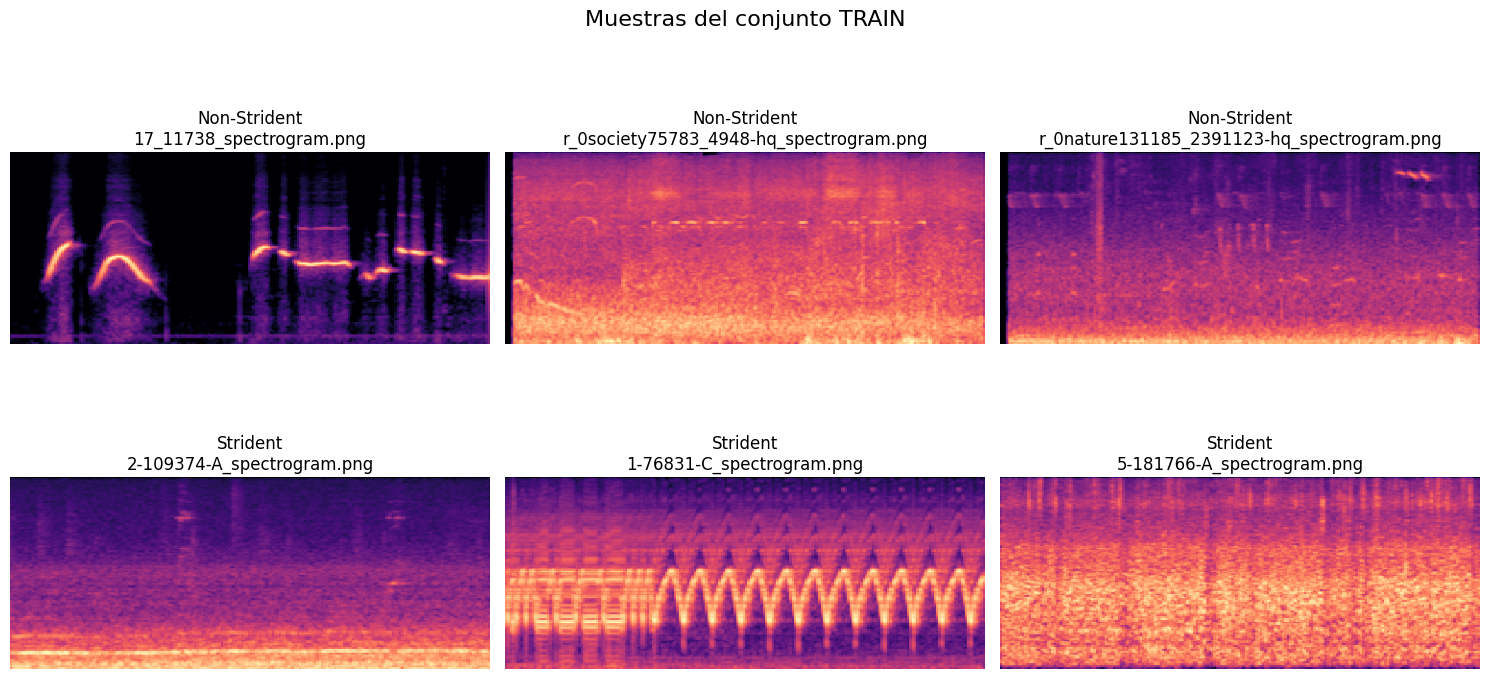

In [ ]:
# Mostrar imágenes de muestra
load_and_display_sample_images(dataset, split='train', samples_per_class=3)

## Preprocess dataset

In [ ]:
def load_images_as_arrays(dataset, split='train', max_per_class=None, target_size=(500, 200)):
    """
    Carga las imágenes como arrays de numpy para machine learning,
    redimensionando a un tamaño objetivo.
    """
    import numpy as np
    from PIL import Image

    X = []  # imágenes
    y = []  # etiquetas
    filenames = []

    classes = ['Non-Strident', 'Strident']

    print(f"Cargando imágenes del conjunto {split.upper()} y redimensionando a {target_size}...")

    for i, class_name in enumerate(classes):
        images = dataset[split][class_name]

        if max_per_class:
            images = images[:max_per_class]

        print(f"  Cargando {len(images)} imágenes de {class_name}...")

        for img_path in images:
            try:
                with Image.open(img_path) as img:
                    # Convertir a RGB si es necesario
                    if img.mode != 'RGB':
                        img = img.convert('RGB')

                    # Redimensionar imagen
                    img_resized = img.resize(target_size)

                    # Convertir a array
                    img_array = np.array(img_resized)

                    X.append(img_array)
                    y.append(i)  # 0 para Non-Strident, 1 para Strident
                    filenames.append(os.path.basename(img_path))

            except Exception as e:
                print(f"Error cargando {img_path}: {e}")

    X = np.array(X)
    y = np.array(y)

    print(f"✅ Cargadas {len(X)} imágenes con forma {X.shape}")
    return X, y, filenames

In [ ]:
# 5. Cargar imágenes como arrays para machine learning
X_train, y_train, train_names = load_images_as_arrays(dataset, 'train')
X_test, y_test, test_names = load_images_as_arrays(dataset, 'test')
X_val, y_val, val_names = load_images_as_arrays(dataset, 'val')

print(f"Forma de datos de entrenamiento: {X_train.shape}")
print(f"Etiquetas de entrenamiento: {y_train.shape}")

Cargando imágenes del conjunto TRAIN y redimensionando a (500, 200)...
  Cargando 581 imágenes de Non-Strident...
  Cargando 801 imágenes de Strident...
✅ Cargadas 1382 imágenes con forma (1382, 200, 500, 3)
Cargando imágenes del conjunto TEST y redimensionando a (500, 200)...
  Cargando 72 imágenes de Non-Strident...
  Cargando 100 imágenes de Strident...
✅ Cargadas 172 imágenes con forma (172, 200, 500, 3)
Cargando imágenes del conjunto VAL y redimensionando a (500, 200)...
  Cargando 72 imágenes de Non-Strident...
  Cargando 100 imágenes de Strident...
✅ Cargadas 172 imágenes con forma (172, 200, 500, 3)
Forma de datos de entrenamiento: (1382, 200, 500, 3)
Etiquetas de entrenamiento: (1382,)


In [ ]:
# 2. PREPROCESAMIENTO DE DATOS
def preprocess_data(X_train, X_test, X_val):
    """
    Preprocesa los datos para entrenamiento
    """
    print("🔧 Preprocesando datos...")

    # Normalizar píxeles (0-255 -> 0-1)
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    X_val = X_val.astype('float32') / 255.0


    print(f"✅ Datos preprocesados:")
    print(f"   Training: {X_train.shape}")
    print(f"   Test: {X_test.shape}")
    print(f"   Validation: {X_val.shape}")

    return X_train, X_test, X_val

In [ ]:
X_train, X_test, X_val = preprocess_data(X_train, X_test, X_val)

🔧 Preprocesando datos...
✅ Datos preprocesados:
   Training: (1382, 200, 500, 3)
   Test: (172, 200, 500, 3)
   Validation: (172, 200, 500, 3)


In [ ]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

# CNN model

## Arquitectura

In [ ]:
# CREAR EL MODELO (con input_shape correcto)
def create_cnn_model(input_shape):
    """
    Crea el modelo CNN con la forma de entrada correcta
    """
    print(f"🏗️  Creando modelo CNN con input_shape: {input_shape}")

    model = Sequential()

    # Primera capa convolucional
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))

    # Segunda capa convolucional
    model.add(Conv2D(32, (3, 3), activation='relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))

    # Tercera capa convolucional
    model.add(Conv2D(64, (3, 3), activation='relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))

    # Pooling
    model.add(GlobalAvgPool2D())
    #model.add(Dropout(0.25))

    # Capas densas
    #model.add(Flatten())
    #model.add(Dense(128, activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu'))

    # Salida
    model.add(Dense(2, activation='softmax'))  # 2 clases: Non-Strident y Strident

    # Compilar modelo
    model.compile(
        loss='categorical_crossentropy',
        optimizer='rmsprop',
        metrics=['accuracy']
    )

    return model

In [ ]:
input_shape = X_train.shape[1:]

model = create_cnn_model(input_shape)

# Mostrar resumen del modelo
print("\n📋 Resumen del modelo:")
model.summary()

🏗️  Creando modelo CNN con input_shape: (200, 500, 3)

📋 Resumen del modelo:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 498, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 249, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 247, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 123, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 121, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,874 (108.88 KB)

 Trainable params: 27,874 (108.88 KB)

 Non-trainable params: 0 (0.00 B)

## Training

In [ ]:
# CONFIGURAR CALLBACKS
def setup_callbacks():
    """
    Configura los callbacks para el entrenamiento
    """
    earlystop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    learning_rate_reduction = ReduceLROnPlateau(
        monitor='val_accuracy',  # Cambiado de 'val_acc' a 'val_accuracy'
        patience=3,
        verbose=1,
        factor=0.5,
        min_lr=0.00001
    )

    return [earlystop] # [earlystop, learning_rate_reduction]

# FUNCIÓN PRINCIPAL DE ENTRENAMIENTO
def train_model(model, X_train, y_train, X_val, y_val,
                epochs=50, batch_size=32, verbose=1):
    """
    Entrena el modelo CNN completo
    """
    print("🚀 Iniciando entrenamiento del modelo...")
    print("=" * 60)

    # Configurar callbacks
    callbacks = setup_callbacks()

    # Entrenar modelo
    print(f"\n🎯 Entrenando por {epochs} épocas...")
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=verbose
    )

    # Evaluar en conjunto de prueba
    print("\n📊 Evaluando en conjunto de prueba...")
    test_loss, test_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    return history

# FUNCIÓN PARA VISUALIZAR RESULTADOS
def plot_training_history(history):
    """
    Visualiza la historia del entrenamiento
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
# Entrenar el modelo (esto ejecutará todo el pipeline)
history = train_model(model, X_train, y_train, X_val, y_val,
                            epochs=100, batch_size=64)

🚀 Iniciando entrenamiento del modelo...

🎯 Entrenando por 50 épocas...
Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.5278 - loss: 0.6887 - val_accuracy: 0.5814 - val_loss: 0.6846
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.5878 - loss: 0.6760 - val_accuracy: 0.5814 - val_loss: 0.6653
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.5931 - loss: 0.6654 - val_accuracy: 0.5872 - val_loss: 0.6589
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.6348 - loss: 0.6461 - val_accuracy: 0.5930 - val_loss: 0.6821
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.6528 - loss: 0.6426 - val_accuracy: 0.5756 - val_loss: 0.6556
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.6536 - loss: 0.6322 - val_accuracy: 0.5814 - val_loss: 0.6460
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.6658 - loss: 0.6247 - val_accuracy: 0.6337 - val_loss: 0.6341
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/st

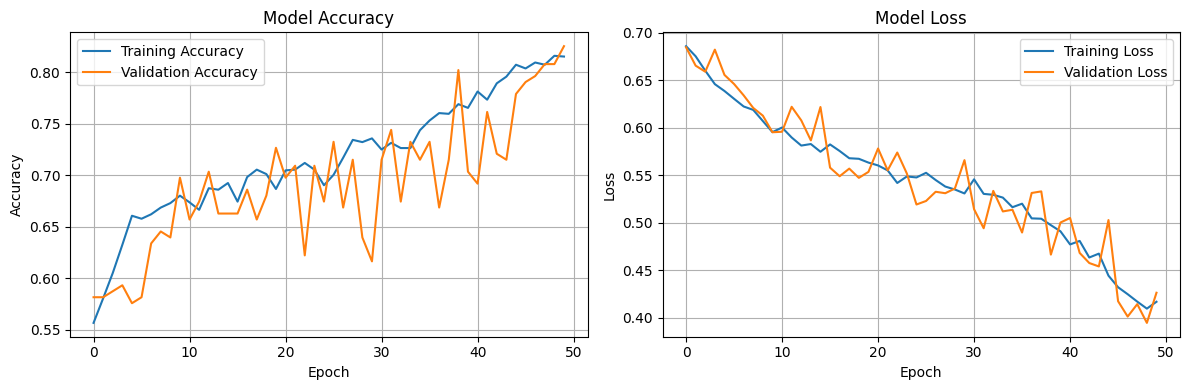

In [ ]:
# Visualizar el progreso del entrenamiento
plot_training_history(history)

## Testing

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score
)

In [ ]:
def comprehensive_model_evaluation(model, X_test, y_test, test_names, num_samples=10, plot_metrics=True):
    """
    Evaluación completa del modelo con todas las métricas típicas

    Args:
        model: Modelo entrenado
        X_test: Datos de prueba
        y_test: Etiquetas verdaderas (one-hot encoded)
        test_names: Nombres de las muestras
        num_samples: Número de predicciones individuales a mostrar
        plot_metrics: Si mostrar los gráficos

    Returns:
        dict: Diccionario con todas las métricas
    """

    # Hacer predicciones
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)

    # Convertir y_test de one-hot a índices de clase
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        true_classes = np.argmax(y_test, axis=1)
    else:
        true_classes = y_test

    class_names = ['Non-Strident', 'Strident']

    '''
    # ========================
    # PREDICCIONES DE MUESTRA
    # ========================
    print("🔍 PREDICCIONES DE MUESTRA")
    print("=" * 60)

    for i in range(min(num_samples, len(X_test))):
        true_class = class_names[true_classes[i]]
        pred_class = class_names[predicted_classes[i]]
        confidence = np.max(predictions[i]) * 100

        status = "✅" if true_classes[i] == predicted_classes[i] else "❌"
        print(f"{status} {test_names[i]}: True: {true_class}, Predicted: {pred_class} ({confidence:.1f}%)")
    '''

    # ========================
    # MÉTRICAS BÁSICAS
    # ========================
    print(f"\n📊 MÉTRICAS DE EVALUACIÓN")
    print("=" * 60)

    # Calcular métricas
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    f1 = f1_score(true_classes, predicted_classes, average='weighted')

    # Métricas por clase
    precision_per_class = precision_score(true_classes, predicted_classes, average=None)
    recall_per_class = recall_score(true_classes, predicted_classes, average=None)
    f1_per_class = f1_score(true_classes, predicted_classes, average=None)

    print(f"🎯 Accuracy (Exactitud): {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"🎯 Precision (Precisión): {precision:.4f}")
    print(f"🎯 Recall (Sensibilidad): {recall:.4f}")
    print(f"🎯 F1-Score: {f1:.4f}")

    print(f"\n📋 MÉTRICAS POR CLASE:")
    print("=" * 60)
    for i, class_name in enumerate(class_names):
        print(f"  {class_name}:")
        print(f"    - Precision: {precision_per_class[i]:.4f}")
        print(f"    - Recall: {recall_per_class[i]:.4f}")
        print(f"    - F1-Score: {f1_per_class[i]:.4f}")

    # ========================
    # MATRIZ DE CONFUSIÓN
    # ========================
    cm = confusion_matrix(true_classes, predicted_classes)

    print(f"\n🔄 MATRIZ DE CONFUSIÓN:")
    print("=" * 60)
    t = ""
    print(f"{t:>16}",end="")
    for name in class_names:
        print(f"{name:>16}", end="")
    print()

    for i, true_name in enumerate(class_names):
        print(f"{true_name:>16}", end="")
        for j in range(len(class_names)):
            print(f"{cm[i,j]:>16}", end="")
        print()

    # Calcular métricas adicionales de la matriz de confusión
    if len(class_names) == 2:  # Para clasificación binaria
        tn, fp, fn, tp = cm.ravel()

        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

        print(f"\n📈 MÉTRICAS ADICIONALES (Clasificación Binaria):")
        print("=" * 60)
        print(f"  True Positives (TP): {tp}")
        print(f"  True Negatives (TN): {tn}")
        print(f"  False Positives (FP): {fp}")
        print(f"  False Negatives (FN): {fn}")
        print(f"  Specificity (Especificidad): {specificity:.4f}")
        print(f"  Sensitivity (Sensibilidad): {sensitivity:.4f}")

    # ========================
    # REPORTE DE CLASIFICACIÓN
    # ========================
    print(f"\n📝 REPORTE DETALLADO DE CLASIFICACIÓN:")
    print("=" * 60)
    print(classification_report(true_classes, predicted_classes, target_names=class_names))

    # ========================
    # GRÁFICOS
    # ========================
    if plot_metrics:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Métricas de Evaluación del Modelo', fontsize=16, fontweight='bold')

        # 1. Matriz de Confusión
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names, ax=axes[0,0])
        axes[0,0].set_title('Matriz de Confusión')
        axes[0,0].set_xlabel('Predicción')
        axes[0,0].set_ylabel('Valor Real')

        # 2. Métricas por clase
        metrics_data = {
            'Precision': precision_per_class,
            'Recall': recall_per_class,
            'F1-Score': f1_per_class
        }

        x = np.arange(len(class_names))
        width = 0.25

        for i, (metric_name, values) in enumerate(metrics_data.items()):
            axes[0,1].bar(x + i*width, values, width, label=metric_name)

        axes[0,1].set_xlabel('Clases')
        axes[0,1].set_ylabel('Puntuación')
        axes[0,1].set_title('Métricas por Clase')
        axes[0,1].set_xticks(x + width)
        axes[0,1].set_xticklabels(class_names)
        axes[0,1].legend()
        axes[0,1].set_ylim(0, 1.1)

        # 3. Distribución de Confianza de Predicciones
        confidence_scores = np.max(predictions, axis=1)
        correct_predictions = (true_classes == predicted_classes)

        axes[1,0].hist(confidence_scores[correct_predictions], alpha=0.7,
                      label='Predicciones Correctas', bins=20, color='green')
        axes[1,0].hist(confidence_scores[~correct_predictions], alpha=0.7,
                      label='Predicciones Incorrectas', bins=20, color='red')
        axes[1,0].set_xlabel('Confianza de Predicción')
        axes[1,0].set_ylabel('Frecuencia')
        axes[1,0].set_title('Distribución de Confianza')
        axes[1,0].legend()

        # 4. ROC Curve (solo para clasificación binaria)
        if len(class_names) == 2:
            # Para ROC necesitamos las probabilidades de la clase positiva
            y_scores = predictions[:, 1]  # Probabilidades para clase 'Strident'
            fpr, tpr, _ = roc_curve(true_classes, y_scores)
            roc_auc = auc(fpr, tpr)

            axes[1,1].plot(fpr, tpr, color='darkorange', lw=2,
                          label=f'ROC curve (AUC = {roc_auc:.2f})')
            axes[1,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            axes[1,1].set_xlim([0.0, 1.0])
            axes[1,1].set_ylim([0.0, 1.05])
            axes[1,1].set_xlabel('Tasa de Falsos Positivos')
            axes[1,1].set_ylabel('Tasa de Verdaderos Positivos')
            axes[1,1].set_title('Curva ROC')
            axes[1,1].legend(loc="lower right")
        else:
            # Para multiclase, mostrar accuracy por muestra
            sample_indices = range(min(50, len(X_test)))
            sample_accuracy = [1 if true_classes[i] == predicted_classes[i] else 0
                             for i in sample_indices]

            axes[1,1].plot(sample_indices, sample_accuracy, 'o-', alpha=0.7)
            axes[1,1].set_xlabel('Índice de Muestra')
            axes[1,1].set_ylabel('Predicción Correcta (1) / Incorrecta (0)')
            axes[1,1].set_title('Precisión por Muestra (primeras 50)')
            axes[1,1].set_ylim(-0.1, 1.1)

        plt.tight_layout()
        plt.show()

    # ========================
    # RETORNAR MÉTRICAS
    # ========================
    metrics_dict = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class,
        'confusion_matrix': cm,
        'predictions': predictions,
        'predicted_classes': predicted_classes,
        'true_classes': true_classes,
        'confidence_scores': np.max(predictions, axis=1)
    }

    if len(class_names) == 2:
        # Añadir métricas específicas para clasificación binaria
        tn, fp, fn, tp = cm.ravel()
        metrics_dict.update({
            'true_positives': tp,
            'true_negatives': tn,
            'false_positives': fp,
            'false_negatives': fn,
            'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
            'sensitivity': tp / (tp + fn) if (tp + fn) > 0 else 0,
            'roc_auc': auc(fpr, tpr) if 'fpr' in locals() else None
        })

    return metrics_dict

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 567ms/step

📊 MÉTRICAS DE EVALUACIÓN
🎯 Accuracy (Exactitud): 0.7500 (75.00%)
🎯 Precision (Precisión): 0.7518
🎯 Recall (Sensibilidad): 0.7500
🎯 F1-Score: 0.7506

📋 MÉTRICAS POR CLASE:
  Non-Strident:
    - Precision: 0.6933
    - Recall: 0.7222
    - F1-Score: 0.7075
  Strident:
    - Precision: 0.7938
    - Recall: 0.7700
    - F1-Score: 0.7817

🔄 MATRIZ DE CONFUSIÓN:
                    Non-Strident        Strident
    Non-Strident              52              20
        Strident              23              77

📈 MÉTRICAS ADICIONALES (Clasificación Binaria):
  True Positives (TP): 77
  True Negatives (TN): 52
  False Positives (FP): 20
  False Negatives (FN): 23
  Specificity (Especificidad): 0.7222
  Sensitivity (Sensibilidad): 0.7700

📝 REPORTE DETALLADO DE CLASIFICACIÓN:
              precision    recall  f1-score   support

Non-Strident       0.69      0.72      0.71        72
    Strident       0.79      0.77      0.78       100

    accuracy         

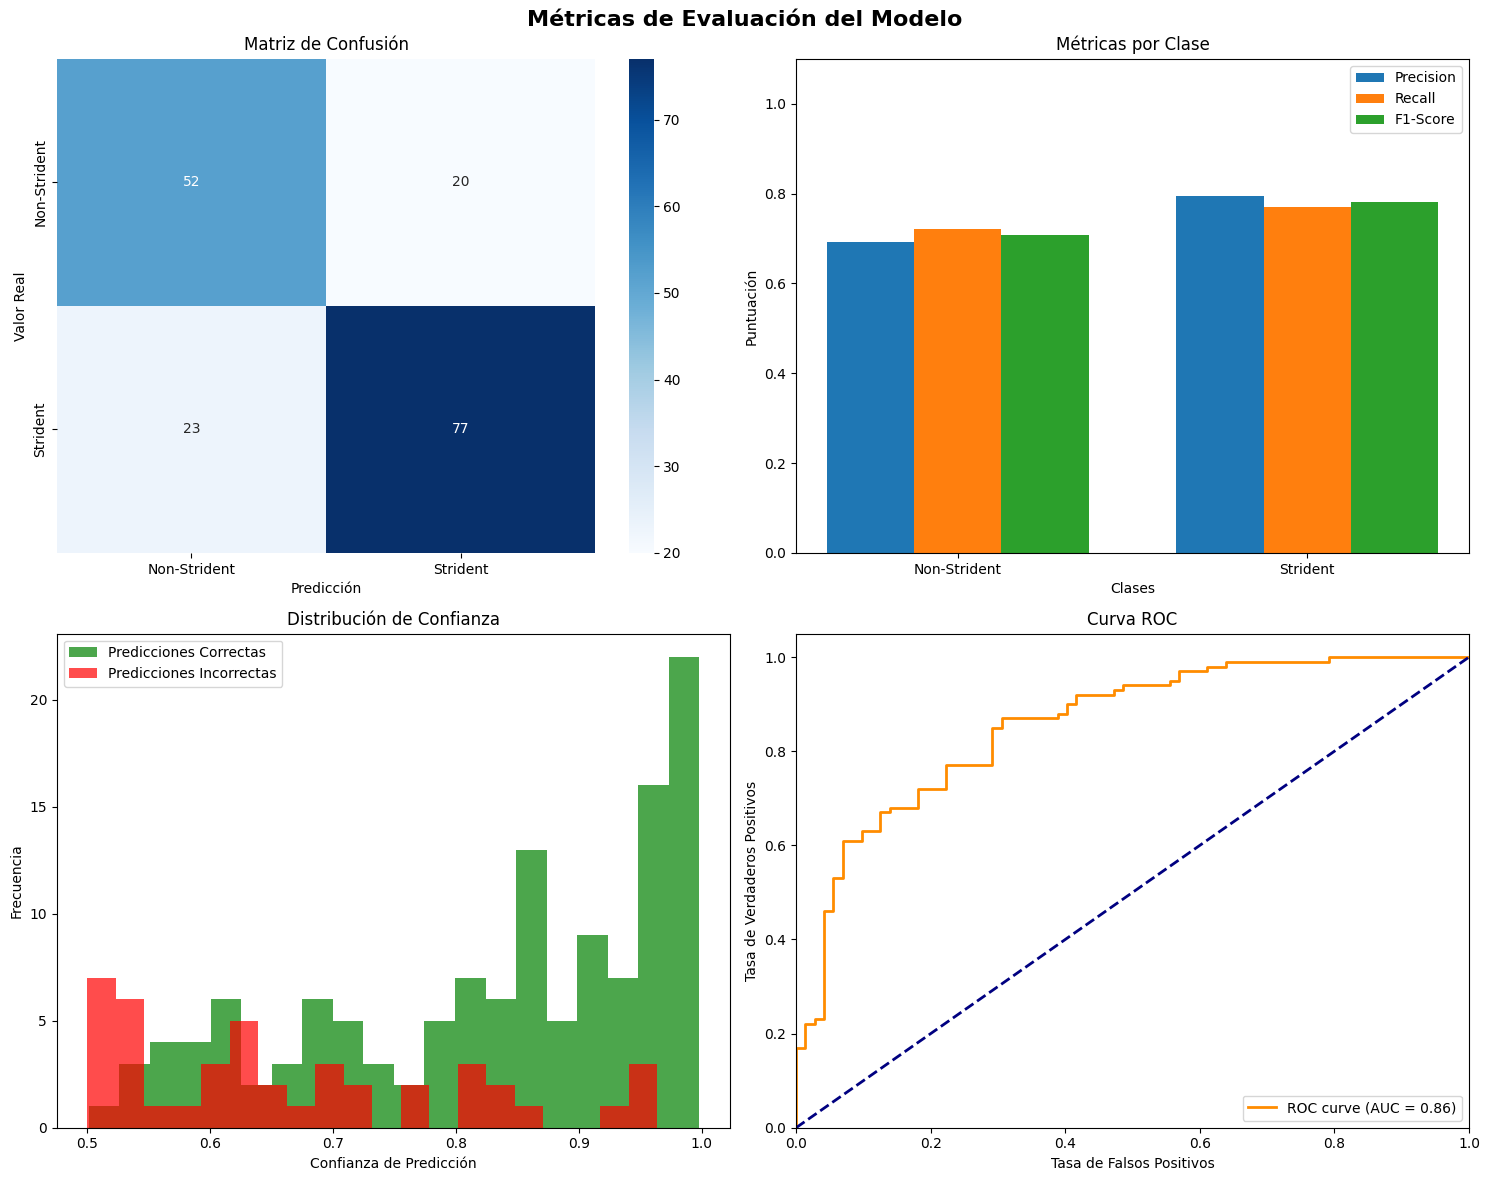

In [ ]:
# Ver predicciones en el conjunto de prueba
metrics = comprehensive_model_evaluation(model, X_test, y_test, test_names)

In [ ]:
# Guardar el modelo entrenado
# model.save('strident_classifier_model.h5')